#Utility and hyperparameters

Connect with google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the seqeval library

In [2]:
!pip3 install seqeval

     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=2aa12f8483af5c2a6971ac7743005d21792e1b724230986f6d258ac528fa07d1
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


Imports

In [3]:
import numpy as np

import random

import json
import os

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Collections
from collections import Counter
from collections import defaultdict

# For word embeddings
import gensim.downloader as api

# For POS
import spacy

# For iteration bars
from tqdm.auto import tqdm

# For plot
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import confusion_matrix as sk_cm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score as sk_precision
from sklearn.metrics import f1_score as sk_f1
from seqeval.metrics import accuracy_score, f1_score

Hyperparameters

In [4]:
# Set the seed for the randoms
def set_random_seed():
  SEED = 104
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
set_random_seed()

# Paths
ROOT = "./drive/MyDrive/NLP/HW1/"
TRAIN_PATH = ROOT + "datasets/train.tsv"
DEV_PATH = ROOT + "datasets/dev.tsv"
MODEL_CHEKPOINT = ROOT + "checkpoints/"
BEST_CHEKPOINT = ROOT + "best_checkpoints/"
VOCAVBULARY = ROOT + "vocab/"

# Vocabulary hyperparameters
MIN_FREQ = 0
WINDOW_SIZE = 100
WINDOW_SHIFT = 100
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
CLASSES = ["B-PER", "B-LOC", "B-GRP", "B-CORP", "B-PROD", "B-CW", "I-PER", "I-LOC", "I-GRP", "I-CORP", "I-PROD", "I-CW", "O"]

# Neural network and train hyperparameters
HIDDEN_DIM = 128
BIDIRECTIONAL = True
NUM_LAYER = 2
DROPOUT = 0.5
LEARNING_RATE = 1e-3
LEN_STACK = 5

Word embedding from gensim.

P.S. I don't know why, but some times this command crash... just re-run until it work

In [5]:
GLOVE_TWITTER = api.load("glove-twitter-200")
print("GLOVE_TWITTER loaded")

[==================================================] 100.0% 758.5/758.5MB downloaded
GLOVE_TWITTER loaded


#Vocabulary


*   Word to id
*   Id to word
*   Label to id
*   Id to Label
*   Frequences



In [6]:
class My_Vocab():
  '''
    Class responsible for creating all vocabularies and data structures useful for:
      - the creation of a dataset;
      - train, validation and testing of a model;
      - encoding and decoding of model inputs and outputs.
  '''
  def __init__(self, 
               train_path, 
               min_freq, 
               classes, 
               unk_token, 
               pad_token, 
               dev_path,
               window_step,
               window_size,
               embedding = None):
    """
      Args:
        train_path: path of the training set.
        min_freq: min frequences for the creation of the vocabulary.
        classes: the classes to predict.
        unk_token: the unknown token.
        pad_token: the padding token.
        dev_path: path of the validation set.
        window_step: shift of the window.
        window_size: size of the window.
        embedding: word embedding.
    """
    # Variable to save
    self.classes = classes
    self.unk = unk_token
    self.pad = pad_token
    self.window_size = window_size
    if ((window_step <1) or (window_step > 0 and window_step > self.window_size)):
      self.window_step = self.window_size
    else:
      self.window_step = window_step

    # For controls
    self.min_freq = min_freq
    self.pos = spacy.load("en_core_web_sm")
    self.embedding = embedding

    # Create sentences for training set
    self.train_path = train_path
    self.sentences = self.read_data(self.train_path, True)
    # Create sentences for validation set
    self.dev_path = dev_path
    self.data_sentences = self.read_data(self.dev_path, False)

    # Create the vocabulary
    self.create_vocabs()

  def save_vocab(self):
    '''
      Save some useful variable to use for testing.
    '''
    json_string = {"classes": self.classes,
                   "UNK_TOKEN": self.unk,
                   "PAD_TOKEN": self.pad,
                   "window_size": self.window_size, 
                   "window_step": self.window_step, 
                   "id2word": self.id2word,
                   "word2id": self.word2id,
                   "id2label": self.id2label,
                   "label2id": self.label2id}
    with open(VOCAVBULARY + "vocabulary.json", 'w') as outfile:
      json.dump(json_string, outfile)    

  def read_data(self, txt_path, mode):
    '''
      Reads and saves sentences within the dataset, 
      adding some POS-based sentences.
      Parameters:
        - txt_path: the path from where to read the dataset;
        - mode: if True I add the sentences based on the POS.
      Return:
        - sentences: sentence dictionary with key the sentence id 
                     and value the sentence which is a list of words 
                     and each word is a pair <text, label>.
    '''
    # Read from the file
    with open(txt_path, mode='r', encoding='utf-8') as json_file:
      json_list = list(json_file)
    sentences = {}
    # For each sentence
    for json_row in json_list:
      entry = json_row[:-1].split("\t")
      # After the end of a sentence there is an empty row
      if (len(entry) == 1):
        continue
      word = entry[0].lower()
      label = entry[1]
      # If the leading character is "#", 
      # then the line describes the id of the sentence
      if (word == "#"):
        sentence_id = entry[2]
        sentences[sentence_id] = []
      else:
        sentences[sentence_id].append(entry)
    # If the mode is True, add the sentences based on the POS
    if (mode):
      for key, sentence in enumerate(self.lemmas_sentences(sentences)):
        # If is a new sentence after the POS manipulation
        if (sentence != sentences[str(key)]):
          sentences[str(len(sentences))] = sentence 
    return sentences 
  
  def lemmas_sentences(self, sentences):
    '''
      For each sentence, I create a new sentence using the lemma 
      generated by the spacy POS, which takes the whole sentence as input. 
      If any words are split up because of this procedure, 
      the individual parts will be labelled the same as the original word.
      Example: [<eaton's, B-CORP>] becomes [<eaton, B-CORP>, <'s, B-CORP>].
      Parameter:
        - sentences: the sentences read by the "read_data" method.
      Return:
        - out: the sentences read by the "read_data" method modified.
    '''
    out = []
    # For each sentence
    for sentence in tqdm(sentences.values(), 
                         desc="Adding new sentences based on POS from spacy", 
                         leave=False): 
      sentence_string = ""
      sentence_words = []
      sentence_labels = []
      lemmas_s = []
      for entry in sentence:
        # Create a sentence given the words
        sentence_string += entry[0] + " "
        # Create a list of the words
        sentence_words.append(entry[0])
        # Create a list of the labels
        sentence_labels.append(entry[1])
      sentence_string = sentence_string[:-1]

      # Manipulate the sentence
      doc = self.pos(sentence_string)
      i = 0
      j = 0
      for token in doc:
        if (token.text == sentence_words[i][j:]):
          lemmas_s.append([token.lemma_, sentence_labels[i]])
          i += 1
          j =0
        else:
          for c in token.text:
            if (c == sentence_words[i][j]):
              j+=1
          lemmas_s.append([token.lemma_, sentence_labels[i]])
      out.append(lemmas_s)
    return out

  def create_vocabs(self):
    '''
      Creates the following data structures: 
        - word2id; 
        - id2word; 
        - label2id; 
        - id2label; 
        - frequencies. 
      The vocabulary is made up of words that have a fixed minimum frequency 
      and, if present, belong to the word embedding.
    '''
    # All-word frequency
    freq = Counter()
    for sentence in self.sentences.values():
      for word in sentence:
          freq[word[0]] += 1
    freq = list(freq.items()) 

    # Frequency skimming
    self.frequences = {}
    for elem in tqdm(freq, desc="Vocabulary creation", leave=False): 
      # Frequency must be greater than or equal to the minimum frequency
      if (elem[1] >= self.min_freq):
        # If there is an embedding
        if (self.embedding != None):
          # If the word is in the embedding
          if (elem[0] in self.embedding):
            self.frequences[elem[0]] = elem[1]
        else:
          self.frequences[elem[0]] = elem[1]
          
    print("Original vocabulary size =", 
          len(freq) + 2, # +2 for unk token and pad
          "\nBut we took the word with at least", 
          self.min_freq, "occurrences", 
          "which are inside the embedding" if self.embedding != None else "", 
          "\nNow the vocabulary size is =", 
          len(self.frequences) + 2) # +2 for unk token and pad

    # self.word2id = {word: id}
    self.word2id = {}
    # self.id2word = {id: word}
    self.id2word = {}
    # self.word2id and self.id2word are parallel
    for id, word in enumerate(self.frequences.keys()):
      self.word2id[word] = id
      self.id2word[id] = word
    # unk token
    self.word2id[self.unk] = id + 1
    self.id2word[id + 1] = self.unk
    # pad token
    self.word2id[self.pad] = id + 2
    self.id2word[id + 2] = self.pad
    
    # self.label2id = {label: id}
    self.label2id = {}
    # self.id2label = {id: label}
    self.id2label = {}
    # self.word2id and self.id2word are parallel
    for id, label in enumerate(self.classes):
      self.label2id[label] = id
      self.id2label[id] = label
    # pad label
    self.label2id[self.pad] = id + 1
    self.id2label[id + 1] = self.pad

  def __len__(self):
    '''
      Return:
        - number of word in the vocabulary
    '''
    return len(self.word2id)

  def encode_text(self, sentence):
    '''
      Turns a sentence made of text into a sentence made of ids.
      Parameter:
        - sentence: a sentence made of text
      Return:
        - ids: a sentence made of ids
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    ids = []
    # For each entry in the sentence
    for entry in sentence:
      # If is None is a padding
      if (entry is None):
        ids.append(self.word2id[PAD_TOKEN])
      # If present in the vocabulary set its id
      elif (self.word2id.get(entry[0]) != None):
        ids.append(self.word2id[entry[0]])
      # Else is an unknown
      else:
        ids.append(self.word2id[UNK_TOKEN])
    return ids

  def decode_output(self, outputs):
    '''
      Transforms a series of label indices into their textual value.
      Parameter:
        - outputs: predictions made by a model in the form of ids
      Return:
        - predictions: predictions made by a model translated into text
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    # From (batch_size, window_size, classes) to (batch_size, window_size)
    max_indices = torch.argmax(outputs, -1).tolist()
    predictions = []
    for indices in max_indices:
      predictions.append([self.id2label[i] for i in indices])
    return predictions

print("VOCABULARY CREATION:")
vocab = My_Vocab(TRAIN_PATH, 
                 MIN_FREQ, 
                 CLASSES, 
                 UNK_TOKEN, 
                 PAD_TOKEN, 
                 DEV_PATH, 
                 WINDOW_SHIFT,
                 WINDOW_SIZE,
                 embedding = GLOVE_TWITTER.vocab)
vocab.save_vocab()
print("\nVocabulary saved!")

VOCABULARY CREATION:


Adding new sentences based on POS from spacy:   0%|          | 0/14535 [00:00<?, ?it/s]

Vocabulary creation:   0%|          | 0/32082 [00:00<?, ?it/s]

Original vocabulary size = 32084 
But we took the word with at least 0 occurrences which are inside the embedding 
Now the vocabulary size is = 23887

Vocabulary saved!


#Datasets

In [8]:
class My_Dataset(Dataset):
  '''
    Class that takes care of creating the dataset, 
    creating tensors that can be used with the model, 
    representing windows of fixed length, 
    which are filled with the words of the sentence plus, if necessary, the padding.
    P.S. For this class I have taken inspiration from the Notebook 6 shown in the lecture
  '''
  def __init__(self, vocab, trdev = "train", device = "cuda"):
    """
      Args:
        vocab: the vocabulary.
        trdev: "train" if is training set, "dev" if is validation set.
        device: "cuda" or "cpu".
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    """
    # Vocabulary
    self.vocabulary = vocab
    
    # Device "cuda" or "cpu"
    self.device = device

    # Window size and shift
    self.window_size = self.vocabulary.window_size
    self.window_shift = self.vocabulary.window_step
    
    # Variable that tells me whether I am creating the training dataset 
    # or the validation dataset
    self.trdev = trdev
    # If it is a training dataset then I take the sentences from 
    # the sentences attribute of the vocabulary, 
    # otherwise from the data_sentences attribute.
    self.sentences = self.vocabulary.sentences if trdev == "train" else self.vocabulary.data_sentences
    
    # Create the windows
    self.data = self.create_windows(self.sentences)

    # Create the data in the dataset
    self.index_dataset()

  def create_windows(self, sentences):
    '''
      Creates fixed-length windows that cover the entire sentence. 
      If the last window exceeds the end of the sentence, 
      then the sentence is filled with padding represented by "None".
      Parameter: 
        - sentences: sentences given by the vocabulary.
      Return: 
        - data: list of windows covering all sentences.
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    data = []
    # For each sentence
    for sentence in sentences.values():
      # Create the window slice
      for i in range(0, len(sentence), self.window_shift):
        window = sentence[i:i+self.window_size]
        # If is the last window, fill with None and continue to the next sentence
        if len(window) < self.window_size:
          window = window + [None]*(self.window_size - len(window))
          data.append(window)
          break
        data.append(window)
    return data

  def index_dataset(self):
    '''
      Creates a dataset entry which is a dictionary with "inputs" and "outputs" 
      representing respectively the input tensor window to be given to the model 
      and the label window to be given to the loss function.
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    self.encoded_data = []
    # For each window
    for elem in tqdm(self.data, desc = "Index dataset", leave = False):
      # Translate the words in ids
      encoded_elem = torch.LongTensor(self.vocabulary.encode_text(elem)).to(self.device)
      label_ids = []
      # Translate the labels in ids
      for entry in elem:
        if (entry is not None):
          label = entry[1]
          label_ids.append(self.vocabulary.label2id[label])
        else:
          label_ids.append(self.vocabulary.label2id[PAD_TOKEN])
      encoded_labels = torch.LongTensor(label_ids).to(self.device)
      # Append the new entry
      self.encoded_data.append({"inputs":encoded_elem, 
                                "outputs":encoded_labels})
    print("Number of inputs:", len(self.encoded_data))

  def __len__(self):
    '''
      Return:
        - number of element in the dataset
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    return len(self.data)

  def __getitem__(self, idx):
    '''
      Return:
        - i-th element of the dataset to iterate on it
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    return self.encoded_data[idx]

print("TRAIN DATASET:")
train_dataset = My_Dataset(vocab, "train")
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print("\nDEV DATASET:")
dev_dataset = My_Dataset(vocab, "dev")
dev_dataloader = DataLoader(dev_dataset, batch_size=128, shuffle=False)

TRAIN DATASET:


Index dataset:   0%|          | 0/28118 [00:00<?, ?it/s]

Number of inputs: 28118

DEV DATASET:


Index dataset:   0%|          | 0/765 [00:00<?, ?it/s]

Number of inputs: 765


#Architecture

In [9]:
class My_Model(nn.Module):
  def __init__(self, hparams):
    """
      Args:
        hparams: all the parameters that we need in the model.
      P.S. For this class I have taken inspiration from the Notebook 6 shown in the lecture
    """
    super(My_Model, self).__init__()
    self.device = hparams.device

    # Random word embedding
    self.word_embedding = nn.Embedding(hparams.vocab_size, 
                                       hparams.word_embedding_dim, 
                                       padding_idx=vocab.word2id[PAD_TOKEN])
    # Pretrained word embedding
    if hparams.word_embeddings is not None:
      self.word_embedding.weight.data.copy_(hparams.word_embeddings)
    
    # LSTM
    self.lstm = nn.LSTM(hparams.word_embedding_dim,
                        hparams.hidden_dim, 
                        bidirectional=hparams.bidirectional,
                        num_layers=hparams.num_layers, 
                        dropout = hparams.dropout if hparams.num_layers > 1 else 0,
                        batch_first = True)
    
    # If is the LSTM is bidirectional, then the output dimension is duplicated
    lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
    
    # Classifier
    self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)
    
    # Dropout to avoid overfitting
    self.dropout = nn.Dropout(hparams.dropout)
  
  def forward(self, x):
    '''
      Forward of the model:
        Input: (batch_size, window_size)
        Output: (batch_size, window_size, num_classes)
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    '''
    # (batch_size, window_size) 
    # The last dim is replaced with index in word embedding
    embeddings = self.word_embedding(x)
    # (batch_size, window_size, embedding_dim)
    embeddings = self.dropout(embeddings)
    o, (h, c) = self.lstm(embeddings)
    # if LSTM  (batch_size, window_size, hidden_dim)
    # if BLSTM (batch_size, window_size, hidden_dim * 2)
    o = self.dropout(o)
    output = self.classifier(o)
    # (batch_size, window_size, num_classes)
    return output

#Training, Validation and Test

In [20]:
from torch.utils.data.dataloader import T
class Trainer():
  """
    Class to train and evaluate a model.
    P.S. For this class I have taken inspiration from the Notebook 6 shown in the lecture
  """
  def __init__(self, model, loss_function, optimizer, vocab):
    """
    Args:
        model: the model we want to train.
        loss_function: the loss_function to minimize.
        optimizer: the optimizer used to minimize the loss_function;
        vocab: the vocabulary.
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    """
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.vocab = vocab

  def print_bar(self, epoch, epochs, train_loss, step, 
                valid_loss, perc = 0, perc_bar = 0, final = False):
    '''
      Method used for a cute and personalised print during training/validation.
      Parameters:
        - epoch: the number the current epoch;
        - epochs: the number of the max epoch;
        - train_loss: training loss accumulated;
        - step: the number of the current batch;
        - valid_loss: the average validation loss;
        - perc: percentage of batches processed;
        - perc_bar: percentage of batches processed 
                    as "=" for the bar to be printed;
        - final: if it is an end of epoch print to eliminate graphic artefacts;
    '''
    if (final):
      print("\rEpoch " + str(epoch+1) + "/" + str(epochs) + 
            ": 100% [" + "="*self.perc_bar_steps + "];\t" + 
            "Train loss = " + str(round(train_loss/step, 4)) + ";\t" + 
            "Valid loss = " + str(round(valid_loss, 4)) + ";\t" + 
            "Patience: [" + "="*(self.patience) + "-"*(len(self.patience_emoji) - self.patience - 1) + "] " + 
            self.patience_emoji[self.patience] + "        ", end = '')
    else:
      print("\rEpoch " + str(epoch+1) + "/" + str(epochs) + 
                ": " + str(perc) + "% [" + "="*perc_bar + "-"*(self.perc_bar_steps-perc_bar) + "];\t" + 
                "Train loss = " + str(round(train_loss/(step + 1), 4)) + ";\t" + 
                "Valid loss = " + str(round(valid_loss, 4)) + ";\t" + 
                "Patience: [" + "="*(self.patience) + "-"*(len(self.patience_emoji) - self.patience - 1) + "] " + 
                self.patience_emoji[self.patience] + "        ", end = '')

  def save_model(self, epoch):
    '''
      Method used for save the model.
      Parameter:
        - epoch: the number the current epoch;
    '''
    torch.save(self.model.state_dict(),
                          os.path.join(MODEL_CHEKPOINT, "state_{}.pt".format(epoch+1)))

  def train(self, train_dataset, valid_dataset, epochs = 100):
    """
      Train the model.
      Parameterss:
        train_dataset: a Dataset or DatasetLoader instance containing 
                       the training instances;
        valid_dataset: a Dataset or DatasetLoader instance used to evaluate
                       learning progress;
        epochs: the number of times to iterate over train_dataset.
      Returns:
        train_losses: list of the training losses over the epochs;
        valid_losses; list of the validation losses over the epochs;
        epoch: number of the last epoch (less than epochs if early stopepd).
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    """
    # EARLY STOPPING VARIABLES
    # Emoji print to display the status of patience
    self.patience_emoji = [":D", ":)", ":|", ":/", ":C"]
    # Current patience
    self.patience = 0
    # Temporal window of validation losses
    self.patience_stack = [1000 for _ in range(LEN_STACK*2)]
    
    # Max lenght of the process bar
    self.perc_bar_steps = 10

    # Number of samples in the training set
    self.n_sample = len(train_dataset)
    # List of training losses
    train_losses = []

    # List of training losses
    valid_losses = []
    # Validation loss
    valid_loss = 0.0

    # Start!
    for epoch in range(epochs):
      # Start training
      epoch_loss = 0.0
      self.model.train()

      # for each batch 
      for step, sample in enumerate(train_dataset):
        # Sample
        inputs = sample['inputs']
        labels = sample['outputs']

        self.optimizer.zero_grad()

        # Predictions
        predictions = self.model(inputs)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        
        # Compute loss
        sample_loss = self.loss_function(predictions, labels)
        sample_loss.backward()

        self.optimizer.step()

        epoch_loss += sample_loss.tolist()      
        
        # Print informations
        perc = round(100*step/self.n_sample, 2)
        perc_bar = int(perc/self.perc_bar_steps)
        if (step%10 == 0):
          self.print_bar(epoch, epochs, epoch_loss, step, 
                         valid_loss, perc = perc, perc_bar = perc_bar)
      
      # training epoch loss
      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_losses.append(avg_epoch_loss)
      # validation loss
      valid_loss = self.evaluate(valid_dataset)
      valid_losses.append(valid_loss)

      # Print informations
      self.print_bar(epoch, epochs, epoch_loss, len(train_dataset), 
                     valid_loss, final = True)
      # Save checkpoint
      self.save_model(epoch)

      # Patience check
      patience_counter = 0
      # Count how many times the validation loss is greater than 
      # that obtained in the previous LEN_STACK*2 epochs
      for past_val_loss in self.patience_stack:
        if past_val_loss < valid_loss:
          patience_counter += 1
      # If it is greater than at least LEN_STACK epochs, 
      # then increase the patience
      if (patience_counter >= LEN_STACK):
        self.patience += 1
      # Otherwise decrease it
      else:
        self.patience -= 1
        if self.patience < 0:
          self.patience = 0
      # If the patience has reached its limit... early stopping!
      if (self.patience == len(self.patience_emoji)):
        self.patience -= 1
        # Print informations
        self.print_bar(epoch, epochs, epoch_loss, len(train_dataset), 
                         valid_loss, final = True)
        print()
        print("Early stopping!!")
        break
      self.patience_stack = self.patience_stack[1:] + [valid_loss]
    return train_losses, valid_losses, epoch
  

  def evaluate(self, valid_dataset):
    """
      Evaluate the model.
      Parameter:
        valid_dataset: the dataset to use to evaluate the model.
      Return:
          avg_valid_loss: the average validation loss over valid_dataset.
      P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
    """
    valid_loss = 0.0
    # set dropout to 0 and dont compute gradient.
    self.model.eval()
    with torch.no_grad():
      sentences = []
      for step, sample in enumerate(valid_dataset):
        # Sample
        inputs = sample['inputs']
        labels = sample['outputs']

        # Make the predictions
        predictions = self.model(inputs)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        # Compute the loss
        sample_loss = self.loss_function(predictions, labels)
        valid_loss += sample_loss.tolist()                    
    return valid_loss / len(valid_dataset)

  def predict_and_scores(self, test_set, checkpoint = None):
    """
      Make a prediction on test set and visualize the scores. 
      The entire method is copied and adapted from the one 
      written in implementation.py. 
      This is why some almost unnecessary calculations are done 
      in order to have an input of the same format as the one 
      passed to the predict function in implementation.py.
      Parameters:
        test_set: the dataloader of the test set;
        checkpoint: path of the model checkpoint.
      P.S. For this method, in particulare for the sklean scores, 
           I have taken inspiration from the Notebook 6 shown in the lecture
    """
    # Load the model checkpoint
    if (checkpoint != None):
      self.model.load_state_dict(torch.load(checkpoint))
    # set dropout to 0 and dont compute gradient.
    self.model.eval()
    with torch.no_grad():
      l_dataset = test_set 
      l_label_vocab = self.vocab.id2label
      sentences = []
      # Create the sentences list in the same format of the implementation.py
      for indexed_elem in tqdm(l_dataset, desc = "Create input", leave = False):
        indexed_in = indexed_elem["inputs"].cpu().detach().numpy().tolist()
        indexed_labels = indexed_elem["outputs"].cpu().detach().numpy().tolist()
        sentence_in = []
        sentence_label = []
        for window_i, window_l in zip(indexed_in, indexed_labels):
          sentence_in.append(window_i)
          sentence_label.append(window_l)
          if (window_i[-1] == vocab.word2id[PAD_TOKEN]):
            sentences.append({"inputs": sentence_in, "outputs": sentence_label})
            sentence_in = []
            sentence_label = []

      decoded_predictions = []
      labels = []
      # For each sentence
      for sentence_i, sentence in tqdm(enumerate(sentences), desc = "Sentences prediction", leave = False):
        index = 0
        # Dictionary having as key the position of a word within a whole sentence 
        # (not divided into windows) and as value 
        # a list of predictions obtained for that word.
        word_predictions = defaultdict(lambda : [])
        sentence_labels = {}
        # For each window
        for window_i, window in enumerate(sentence["inputs"]):
          batch1 = torch.tensor(window).to(self.model.device).unsqueeze(0)
          # Make the prediction
          prediction = self.model(batch1).squeeze()
          # Updates the dictionary word_predictions with the predictions obtained in this window
          for window_index, predicted_label in enumerate(prediction):
            word_predictions[window_index + index].append(predicted_label)
            sentence_labels[window_index + index] = sentences[sentence_i]["outputs"][window_i][window_index]
          index += vocab.window_step

        # For each word, calculate the average prediction
        sentence_prediction = np.zeros((max(list(word_predictions.keys())) + 1, len(vocab.classes) + 1))
        for key, value in word_predictions.items():
          sentence_prediction[key] = torch.mean(torch.stack(value), 0).cpu().detach().numpy()

        # Take the argmax from this new prediction and decode
        sentence_prediction_decoded = []
        for pred in sentence_prediction:
          indices = torch.argmax(torch.tensor(pred).unsqueeze(0), -1).tolist() 
          predictions = []
          for i in indices:
            label = vocab.id2label[i]
            if (label == PAD_TOKEN):
              label = "O"
            predictions.append(label)
          sentence_prediction_decoded.append(predictions[0])

        # Return at the original size of the sentences
        last_window = sentence["inputs"][-1]
        first_pad_index = len(sentence_prediction_decoded)
        if vocab.word2id[PAD_TOKEN] in last_window:
          first_pad_index = -vocab.window_size + np.argmax(np.array(last_window)==vocab.word2id[PAD_TOKEN])
        sentence_prediction_decoded = sentence_prediction_decoded[:first_pad_index]
        sentence_labels = list(sentence_labels.values())[:first_pad_index]
        decoded_predictions.append(sentence_prediction_decoded)
        labels.append(sentence_labels) 
      
      # If an I-class without a B-class is predicted, 
      # the first occurrence of an I-class in the series becomes a B-class.
      for i in range(len(decoded_predictions)):
        for j in range(len(decoded_predictions[i])):
          if (decoded_predictions[i][j][0] == "I"):
            if (j == 0):
              decoded_predictions[i][j] = "B" + decoded_predictions[i][j][1:]
            index = j
            l = decoded_predictions[i][index]
            while (decoded_predictions[i][index] == l and index > 0):
              index -= 1
            if (decoded_predictions[i][index] != "B" + l[1:]):
              decoded_predictions[i][index+1] = "B" + l[1:]

      # Compute the encoded version of the prediction
      all_predictions = []
      all_labels = []
      decoded_labels = []
      for window_l, window_i in zip(labels, decoded_predictions):
        all_labels += window_l
        w_labels = []
        for label in window_l:
          w_labels.append(vocab.id2label[label])
        decoded_labels.append(w_labels)
        prediction = []
        for label_pred in window_i:
          prediction.append(vocab.label2id[label_pred])
        all_predictions += prediction
      
      # Compute skleang scores
      micro_precision = sk_precision(all_labels, all_predictions, average="micro", zero_division=0)
      macro_precision = sk_precision(all_labels, all_predictions, average="macro", zero_division=0)
      f1 = sk_f1(all_labels, all_predictions, average="macro")
      per_class_precision = sk_precision(all_labels, all_predictions, labels = list(range(len(l_label_vocab))), average=None, zero_division=0)
      all_labels_decoded = []
      all_predictions_decoded = []
      for l, p in zip(all_labels, all_predictions):
        all_labels_decoded.append(vocab.id2label[l])
        all_predictions_decoded.append(vocab.id2label[p])
      c = vocab.classes + [PAD_TOKEN]
      confusion_matrix = sk_cm(all_labels_decoded, all_predictions_decoded, labels=c, normalize = "true")
      
      # Compute seqeval scores
      seqeval_acc = accuracy_score(all_labels_decoded, all_predictions_decoded)
      seqeval_f1 = f1_score(decoded_labels, decoded_predictions, average="macro")
    
      # Print the scores and plot the confusion matrix
      per_class_precision = per_class_precision
      print("Micro Precision: {}\nMacro Precision: {}".format(micro_precision, macro_precision))
      print("F1 score: " + str(f1))
      print("Seqeval Accuracy: " + str(seqeval_acc))
      print("Seqeval F1 score: " + str(seqeval_f1))
      print("Per class Precision:")
      for idx_class, precision in sorted(enumerate(per_class_precision), key=lambda elem: -elem[1]):
        label = vocab.id2label[idx_class]
        print("\t", label, precision)
      print("Confusion Matrix:")
      c = vocab.classes + [PAD_TOKEN]

      disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                                    display_labels=c)
      fig, ax = plt.subplots(figsize=(13,13))
      disp.plot(ax=ax)
      plt.grid(False)
      plt.show()

def create_embedding(emb, name):
  '''
    Function that create the weight of the embedding
    Parameters:
      - emb: pretrained embedding
      - name: name of the pretrained embedding
    Return:
      - pretrained_embeddings: weight of the pretrained embedding based on vocabulary words
    P.S. For this method I have taken inspiration from the Notebook 6 shown in the lecture
  '''
  print("Load embedding " + name + "...")
  pretrained_embeddings = torch.randn(len(vocab), emb.vectors.shape[1])
  initialised = 0
  for id, word in tqdm(vocab.id2word.items(), desc="Word embedding", leave=False):
    if word in emb.vocab:
      initialised += 1
      vec = torch.from_numpy(emb[word])
      pretrained_embeddings[id] = vec
  pretrained_embeddings[vocab.word2id[PAD_TOKEN]] = torch.zeros(emb.vectors.shape[1])
  pretrained_embeddings[vocab.word2id[UNK_TOKEN]] = torch.zeros(emb.vectors.shape[1])
  if (len(vocab) - initialised > 2):
    print("Initialised embeddings for {} words".format(initialised))
    print("Random initialised embeddings for {} words + two random entry for <pad> and <unk>".format(len(vocab) - initialised))
  else:
    print("Initialised embeddings with {} words + two random entry for <pad> and <unk>".format(initialised))
  return pretrained_embeddings

class HParams():
  '''
    Hyperparameters to be passed to the model
  '''
  vocab_size = len(vocab)
  hidden_dim = HIDDEN_DIM
  num_classes = len(CLASSES) + 1
  bidirectional = BIDIRECTIONAL
  num_layers = NUM_LAYER
  dropout = DROPOUT
  word_embeddings = None
  word_embedding_dim = 300
  device = "cuda"
params = HParams()

# Set the random's seed
set_random_seed()

# Initialize the pretrained embeddings
pretrained_word_embeddings = create_embedding(GLOVE_TWITTER, "GLOVE_TWITTER")
params.word_embedding_dim = pretrained_word_embeddings.shape[1]
params.word_embeddings = pretrained_word_embeddings
print("\nInitialise the model")

# Initialize the model
my_model = My_Model(params).cuda()
print(my_model)

# Initialize the trainer
optimizer = torch.optim.Adam(my_model.parameters(), lr = LEARNING_RATE)
loss_function = nn.CrossEntropyLoss(ignore_index=vocab.label2id[PAD_TOKEN])
trainer = Trainer(
    model = my_model,
    loss_function = loss_function,
    optimizer = optimizer,
    vocab = vocab
)

Load embedding GLOVE_TWITTER...


Word embedding:   0%|          | 0/23887 [00:00<?, ?it/s]

Initialised embeddings with 23885 words + two random entry for <pad> and <unk>

Initialise the model
My_Model(
  (word_embedding): Embedding(23887, 200, padding_idx=23886)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (classifier): Linear(in_features=256, out_features=14, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Train and validation

Epoch 13/100: 100% [==========];	Train loss = 0.0953;	Valid loss = 0.2937;	Patience: [====] :C        
Early stopping!!

The lowest loss is at the epoch 6


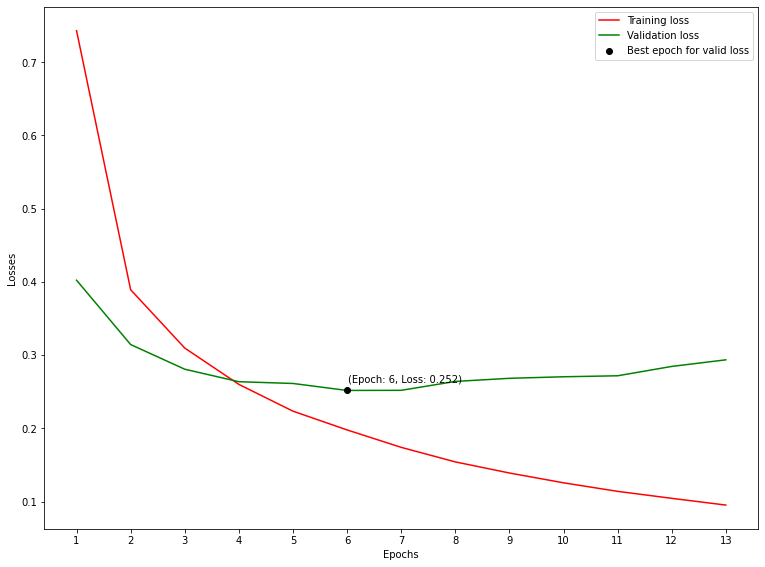

In [21]:
epochs = 100
train_losses, valid_losses, epoch = trainer.train(train_dataloader, dev_dataloader, epochs)
ep = np.arange(1,epoch+2,1)

print()
print("The lowest loss is at the epoch", np.argmin(valid_losses)+1)

# PLOTS
plt.figure(figsize=(6.4*2, 4.8*2), constrained_layout=False)
# Validation and training curve
plt.plot(ep, train_losses, c = "red", label = "Training loss")
plt.plot(ep, valid_losses, c = "green", label = "Validation loss")
# Best epoch fot validation loss
plt.scatter(np.argmin(valid_losses)+1, valid_losses[np.argmin(valid_losses)], 
            c = "black", label = "Best epoch for valid loss", zorder=3)
plt.text(np.argmin(valid_losses)+1 + 0.01, valid_losses[np.argmin(valid_losses)] + 0.01, 
         '(Epoch: {}, Loss: {})'.format(np.argmin(valid_losses)+1, 
                                        np.round(valid_losses[np.argmin(valid_losses)], 3)), 
         zorder=4)
# Aesthetics
plt.xticks(ep)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()

##Testing

###Test the current model

Create input:   0%|          | 0/6 [00:00<?, ?it/s]

Sentences prediction: 0it [00:00, ?it/s]

Micro Precision: 0.9275350952866442
Macro Precision: 0.7782860999643295
F1 score: 0.7516241182492241
Seqeval Accuracy: 0.9275350952866442
Seqeval F1 score: 0.6548479426605154
Per class Precision:
	 O 0.9599961534762957
	 I-PER 0.8971061093247589
	 B-PER 0.872852233676976
	 I-GRP 0.8636363636363636
	 I-LOC 0.8421052631578947
	 B-LOC 0.8363636363636363
	 B-GRP 0.7777777777777778
	 I-PROD 0.7564102564102564
	 I-CORP 0.7383177570093458
	 B-CORP 0.6984126984126984
	 B-PROD 0.6885245901639344
	 I-CW 0.6613545816733067
	 B-CW 0.5248618784530387
	 <pad> 0.0
Confusion Matrix:


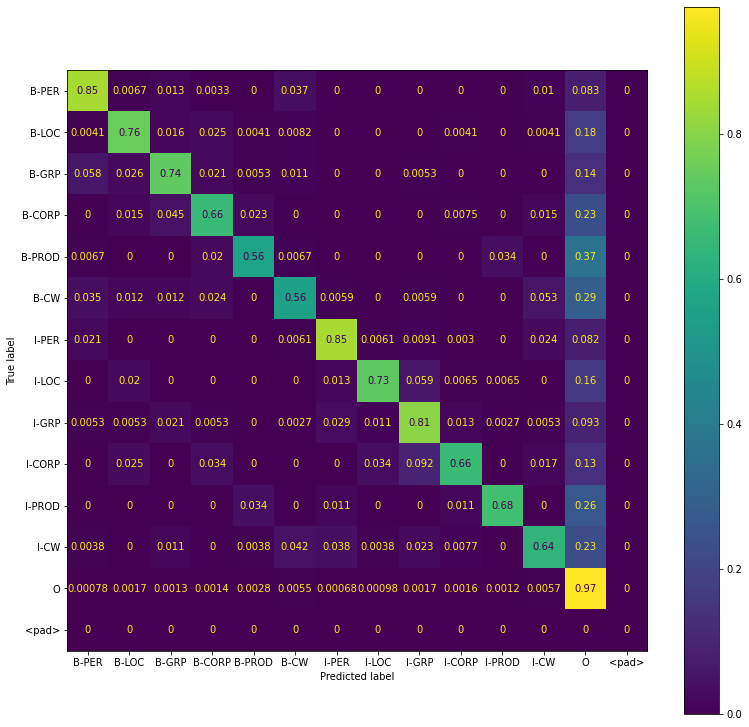

In [ ]:
trainer.predict_and_scores(dev_dataloader)

###Test the best model

Create input:   0%|          | 0/6 [00:00<?, ?it/s]

Sentences prediction: 0it [00:00, ?it/s]

Micro Precision: 0.9279272213944004
Macro Precision: 0.7640977764243746
F1 score: 0.7574234829133377
Seqeval Accuracy: 0.9279272213944004
Seqeval F1 score: 0.6611607177439702
Per class Precision:
	 O 0.9659632402995235
	 I-PER 0.8875
	 B-PER 0.8707482993197279
	 I-GRP 0.842391304347826
	 I-LOC 0.8289473684210527
	 B-LOC 0.8073770491803278
	 I-CORP 0.78
	 B-GRP 0.7421052631578947
	 B-CORP 0.7107438016528925
	 I-PROD 0.6875
	 I-CW 0.6653061224489796
	 B-PROD 0.6282051282051282
	 B-CW 0.5164835164835165
	 <pad> 0.0
Confusion Matrix:


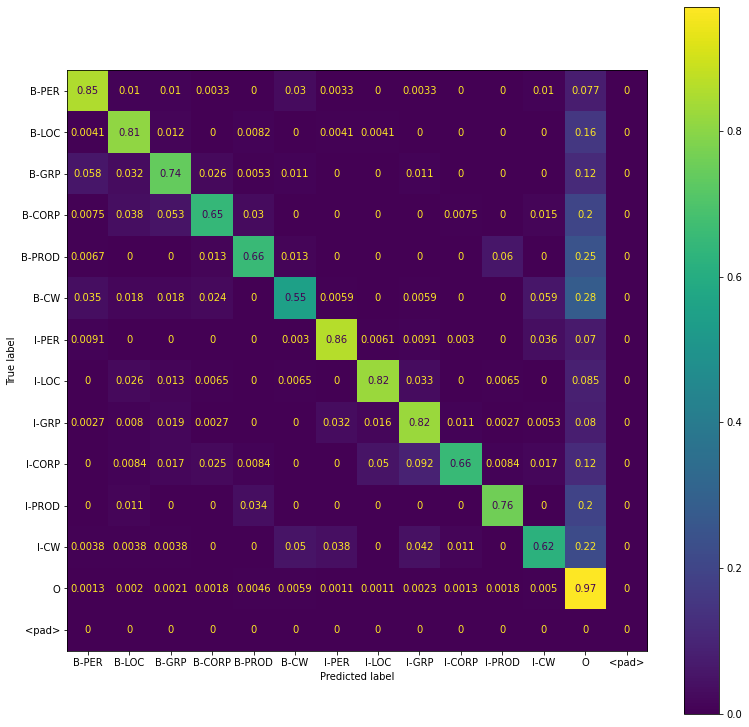

In [ ]:
trainer.predict_and_scores(dev_dataloader, checkpoint = BEST_CHEKPOINT + "chk.pt")